# 4.0 Analysis of A/B testing from Game 1

In [1]:
from game.flaskapp_andrius.api import preprocesser
from game.utils import run_query
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns

from game.src.delta12_calculator import get_delta12_api, get_recipe_id_api, get_recipe_api, get_delta12
from game.src.ab_test_preprocessor import calc_new_delta, get_last_order_hist, get_all_orders, get_order_hist_from_observed
from game.src.feature_generator import get_embedding, get_vector_list

# Inputs

In [2]:
order_history = pd.read_csv('../data/order_history_g1.csv', sep=',')

In [3]:
g_observed = pd.read_csv('../data/tableGame1.csv')

# Change csv output path at the end

# Preprocessing

In [4]:
g_observed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   record_id    840 non-null    int64  
 1   customer_id  831 non-null    float64
 2   que1_rc1     840 non-null    int64  
 3   que1_rc2     840 non-null    int64  
 4   que1_rc3     840 non-null    int64  
 5   que1_rc4     840 non-null    int64  
 6   que1_rc5     840 non-null    int64  
 7   que1_rc6     840 non-null    int64  
 8   que1_rc7     840 non-null    int64  
 9   que1_rc8     840 non-null    int64  
 10  que1_rc9     840 non-null    int64  
 11  que1_rc10    840 non-null    int64  
 12  que2_rc1     840 non-null    int64  
 13  que2_rc2     840 non-null    int64  
 14  que2_rc3     840 non-null    int64  
 15  que2_rc4     840 non-null    int64  
 16  que2_rc5     840 non-null    int64  
 17  que2_rc6     840 non-null    int64  
 18  que2_rc7     840 non-null    int64  
 19  que2_rc8

In [5]:
recipe_cols = g_observed.columns[2:22]
recipe_cols

Index(['que1_rc1', 'que1_rc2', 'que1_rc3', 'que1_rc4', 'que1_rc5', 'que1_rc6',
       'que1_rc7', 'que1_rc8', 'que1_rc9', 'que1_rc10', 'que2_rc1', 'que2_rc2',
       'que2_rc3', 'que2_rc4', 'que2_rc5', 'que2_rc6', 'que2_rc7', 'que2_rc8',
       'que2_rc9', 'que2_rc10'],
      dtype='object')

In [6]:
# Preprocessing order history table
order_history = order_history.reset_index()
order_history.columns = order_history.iloc[0].tolist()
order_history = order_history.drop(0)
order_history = order_history.dropna(subset=['id'])
order_history['id'] = order_history['id'].astype(int)
order_history['delivery_id'] = order_history['delivery_id'].astype(int)
order_history['customer_id'] = order_history['customer_id'].astype(int)
order_history.head(1)

,delivery_id,delivery_date,customer_id,allergens,calories,carbs,cuisine,fat,food_group,protein,...,id,cooking_time,image_url,instructions,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence
1,8089200,2020-03-28,100038,{Soya},493.22,39.71,Mexican,25.40,Vegan,25.43,...,642,30,https://mindfulchef-uat.imgix.net/recipes/642/...,Boil a kettle. Thinly slice the spring onions....,Dragonfly organic extra-firm tofu,Mexican-style beans with scrambled tofu & avocado,Our plant-based take on Mexican scrambled eggs...,950,1200,2250


In [7]:
g_customers = order_history['customer_id'].unique()
g_historical = pd.DataFrame(g_customers, columns=['customer_id'])

In [8]:
# Get updated recipes info and vectors associated with recipes
df_updated_recipes = pd.read_csv('../data/recipe_table_updated_UAT.csv', sep=',')
df_updated_recipes = df_updated_recipes.reset_index()
df_updated_recipes.columns = df_updated_recipes.iloc[0].tolist()
df_updated_recipes = df_updated_recipes.drop(0)
df_updated_recipes['id'] = df_updated_recipes['id'].astype(int)
df_updated_recipes = df_updated_recipes.dropna(subset=['key_ingredient'])

updated_recipe_dict = df_updated_recipes.to_dict(orient='records')
list_of_updated_vectors = get_vector_list(updated_recipe_dict)
df_updated_recipes['vector'] = list_of_updated_vectors
df_updated_recipes.head(1)

,allergens,calories,carbs,cuisine,fat,food_group,protein,season,special,id,cooking_time,image_url,instructions,key_ingredient,title,description,price_1p_pence,price_2p_pence,price_4p_pence,vector
1,"{Mustard,Nuts}",505.84,26.63,British,26.52,Beef,45.71,Spring,NaN,1,25,https://mindfulchef-uat.imgix.net/recipes/1/2e...,"Preheat the oven to 180C / gas mark 4., Trim t...",Grass-fed heritage breed Yorkshire beef,Seared beef with spring vegetable medley,We've paired a succulent seared steak with a m...,900,1400,2400,"[0.0647217469599511, -0.003410175382256585, -0..."


In [9]:
# Preprocessing of observed data from AB testing
g_observed = g_observed.dropna(subset=['customer_id'])
g_observed['customer_id'] = g_observed['customer_id'].astype(int)
g_observed[recipe_cols] = g_observed[recipe_cols].replace(0, np.nan)

In [10]:
# Generate recipe vectors from old recipe table
df_recipes = pd.read_csv('../data/recipe_table.csv', sep=';')
df_recipes['price'] = df_recipes['price_2p_pence']

df_clean = df_recipes[['id', 'food_group', 'calories', 'carbs', 'fat',
                      'protein', 'cooking_time', 'title', 'description',
                      'key_ingredient', 'price']]
recipe_dict = df_clean.to_dict(orient='records')
list_of_vectors = get_vector_list(recipe_dict)
df_clean['vector'] = list_of_vectors
df_vectors = pd.DataFrame(df_clean[['id', 'vector']])

# Historical delta12 and magnitude

In [11]:
# Get historical delta12 values for game-playing customers (can take time)
g_historical['historical_delta12'] = g_historical['customer_id'].apply(lambda x: get_delta12(get_last_order_hist(order_history, x)))

In [12]:
# Get historical pairwise magnitudes for game-playing customers (can take time)
g_historical['historical_magnitude'] = g_historical['customer_id'].apply(lambda x: calc_new_delta(get_all_orders(order_history, x), df_updated_recipes))

In [13]:
g_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           721 non-null    int32  
 1   historical_delta12    721 non-null    float64
 2   historical_magnitude  721 non-null    float64
dtypes: float64(2), int32(1)
memory usage: 14.2 KB


<AxesSubplot:xlabel='historical_delta12', ylabel='Density'>

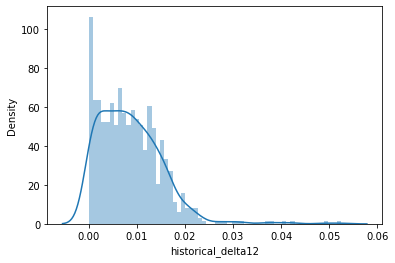

In [14]:
sns.distplot(g_historical['historical_delta12'], bins=60)

<AxesSubplot:xlabel='historical_magnitude', ylabel='Density'>

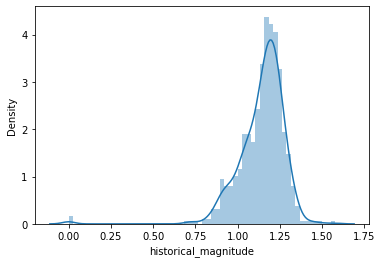

In [15]:
sns.distplot(g_historical['historical_magnitude'], bins=60)

In [16]:
# Sort by customer ID
g_historical = g_historical.sort_values('customer_id')
g_historical.head(5)

,customer_id,historical_delta12,historical_magnitude
298,21,0.000146,0.892655
640,91,0.010483,1.109857
277,138,0.007553,1.449554
324,294,0.022552,1.182459
373,414,0.005375,1.038721


# Observed delta12 and magnitude from AB testing

In [17]:
# Get observed delta12 values
g_observed['observed_delta12'] = g_observed['customer_id'].apply(lambda x: get_delta12(get_order_hist_from_observed(g_observed, x, recipe_cols)))
g_observed.head(1)

,record_id,customer_id,que1_rc1,que1_rc2,que1_rc3,que1_rc4,que1_rc5,que1_rc6,que1_rc7,que1_rc8,...,que2_rc2,que2_rc3,que2_rc4,que2_rc5,que2_rc6,que2_rc7,que2_rc8,que2_rc9,que2_rc10,observed_delta12
0,1,91867,754,562,NaN,NaN,NaN,NaN,NaN,NaN,...,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004335


In [18]:
# Get observed magnitudes (this takes some time to run)
g_observed['observed_magnitude']=0
for i in range(len(g_observed)):
    g_observed['observed_magnitude'].iloc[i] = calc_new_delta(g_observed[recipe_cols].iloc[i].dropna().tolist(), df_vectors)

In [19]:
g_observed_clean = g_observed[['customer_id', 'observed_delta12', 'observed_magnitude']]
g_observed_clean = g_observed_clean.sort_values('customer_id')
g_observed_clean.head(5)

,customer_id,observed_delta12,observed_magnitude
660,21,0.028971,1.345987
488,91,0.008893,1.459032
577,138,0.009295,1.379086
170,294,0.020418,1.317611
46,414,0.004370,0.929298


In [20]:
g_historical.head(5)

,customer_id,historical_delta12,historical_magnitude
298,21,0.000146,0.892655
640,91,0.010483,1.109857
277,138,0.007553,1.449554
324,294,0.022552,1.182459
373,414,0.005375,1.038721


# Merge and export

In [21]:
g_merged = pd.merge(g_historical, g_observed_clean, on='customer_id')

In [22]:
g_merged['diff_delta12'] = g_merged['observed_delta12'] - g_merged['historical_delta12']
g_merged['diff_magnitude'] = g_merged['observed_magnitude'] - g_merged['historical_magnitude']
g_merged.head()

,customer_id,historical_delta12,historical_magnitude,observed_delta12,observed_magnitude,diff_delta12,diff_magnitude
0,21,0.000146,0.892655,0.028971,1.345987,0.028825,0.453332
1,91,0.010483,1.109857,0.008893,1.459032,-0.001590,0.349175
2,138,0.007553,1.449554,0.009295,1.379086,0.001741,-0.070467
3,294,0.022552,1.182459,0.020418,1.317611,-0.002134,0.135152
4,414,0.005375,1.038721,0.004370,0.929298,-0.001005,-0.109423


<AxesSubplot:xlabel='diff_delta12', ylabel='Density'>

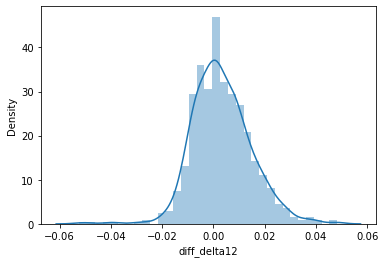

In [23]:
sns.distplot(g_merged['diff_delta12'])

<AxesSubplot:xlabel='diff_magnitude', ylabel='Density'>

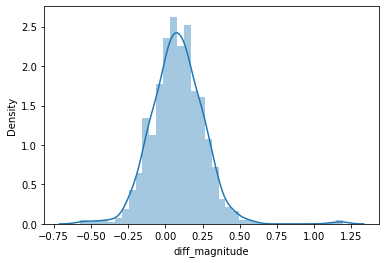

In [24]:
sns.distplot(g_merged['diff_magnitude'])

In [25]:
g_merged['diff_delta12'].describe()

count    804.000000
mean       0.003243
std        0.011522
min       -0.052285
25%       -0.004560
50%        0.002111
75%        0.009785
max        0.048282
Name: diff_delta12, dtype: float64

In [26]:
g_merged['diff_magnitude'].describe()

count    804.000000
mean       0.081721
std        0.177943
min       -0.571191
25%       -0.029410
50%        0.078449
75%        0.189194
max        1.192667
Name: diff_magnitude, dtype: float64

In [27]:
# Export data
g_merged[['diff_delta12', 'diff_magnitude']].to_csv('../data/g1_diff.csv', index=False)